<a href="https://colab.research.google.com/github/MohammadMahdi1375/ClassificationProblem_S3.2/blob/master/Conditional%20GAN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Using TensorFlow backend.


11493376/11490434 [==============================] - 0s 0us/step
(60000, 28, 28, 1)


/usr/local/lib/python3.6/dist-packages/keras/engine/training.py:297: UserWarning: Discrepancy between trainable weights and collected trainable weights, did you set `model.trainable` without calling `model.compile` after ?
  'Discrepancy between trainable weights and collected trainable'
/usr/local/lib/python3.6/dist-packages/tensorflow/python/framework/indexed_slices.py:434: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


0 [D loss: 1.201547622680664] [G loss: 0.17722854018211365]
100 [D loss: 0.00017073423077818006] [G loss: 5.77669470658293e-06]
200 [D loss: 4.2296578612877056e-05] [G loss: 2.3006209630693775e-06]
300 [D loss: 2.6015895855380222e-05] [G loss: 1.599567895027576e-06]
400 [D loss: 2.170461812056601e-05] [G loss: 1.4843636790828896e-06]
500 [D loss: 1.858185714809224e-05] [G loss: 3.085336629737867e-06]
600 [D loss: 6.902680615894496e-05] [G loss: 2.4348633814952336e-05]
700 [D loss: 0.0011415816843509674] [G loss: 0.014909930527210236]
800 [D loss: 0.021007047966122627] [G loss: 4.483214855194092]
900 [D loss: 0.00018183277279604226] [G loss: 4.007055167676299e-07]
1000 [D loss: 0.2020769715309143] [G loss: 3.383793830871582]
1100 [D loss: 0.001842775847762823] [G loss: 0.0329284705221653]
1200 [D loss: 0.012553196400403976] [G loss: 5.114501953125]
1300 [D loss: 0.006208507344126701] [G loss: 5.527072429656982]
1400 [D loss: 0.0012196185998618603] [G loss: 1.967658519744873]
1500 [D los

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:195: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).


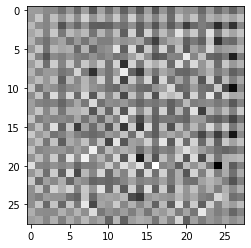

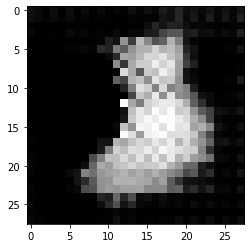

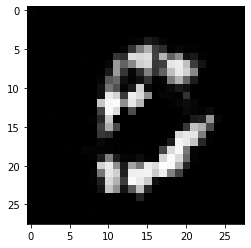

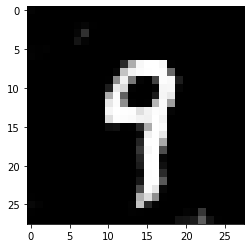

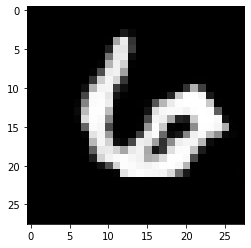

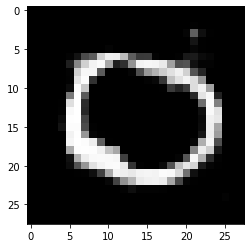

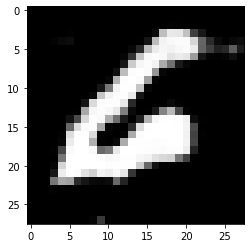

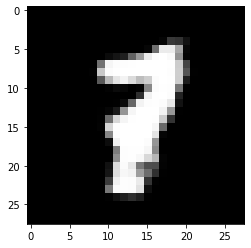

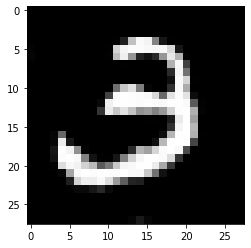

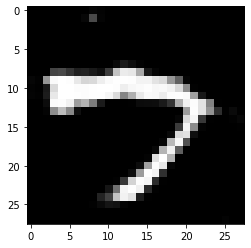

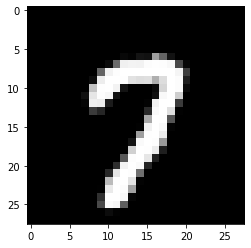

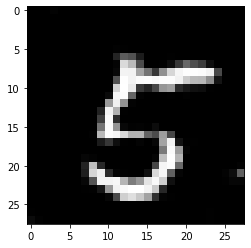

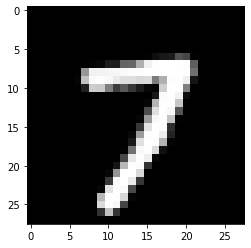

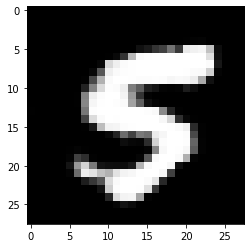

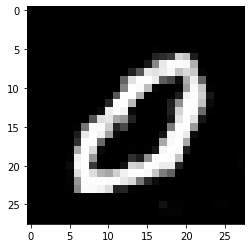

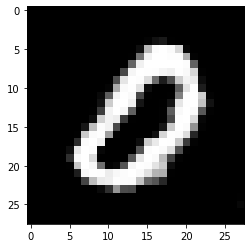

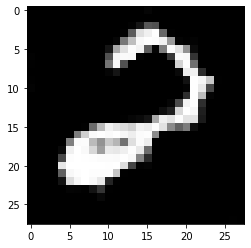

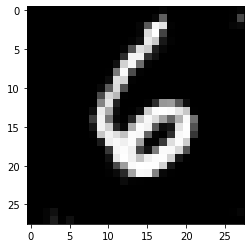

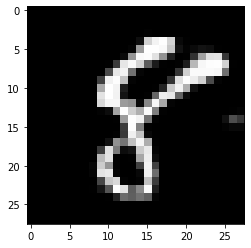

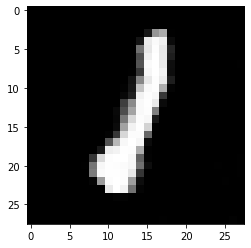

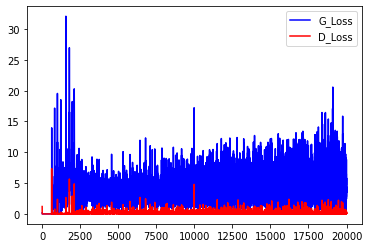

Time elapsed in Second : 844.3739578723907


In [1]:
%tensorflow_version 2.x
import time
from keras import backend as K

from keras.layers import Input, Dense, Reshape, Flatten, Concatenate
from keras.layers import BatchNormalization, Activation, Embedding, multiply
from keras.layers.advanced_activations import LeakyReLU
from keras.layers.convolutional import Conv2D, Conv2DTranspose
from keras.optimizers import Adam
from keras.models import Model, Sequential
from keras.utils import to_categorical

import matplotlib.pyplot as plt
import numpy as np

import tensorflow as tf

%matplotlib inline




class CGAN():
  def __init__(self):
    self.H = 28
    self.W = 28
    self.channel = 1
    self.img_shape = (self.H, self.W, self.channel)
    self.latent_dim = 100
    self.num_classes = 10


    (self.training_input, self.training_output), (_, _) = tf.keras.datasets.mnist.load_data()
    self.training_input = self.training_input/127.5 - 1
    self.training_input = np.expand_dims(self.training_input, axis=3)
    print(self.training_input.shape)


    # building and compiling the Discriminator
    self.Discriminator = self.build_discriminator()
    self.Discriminator.compile(loss='binary_crossentropy', optimizer=Adam())

    # build the generator
    self.Generator = self.build_generator()

    # the generator takes noise and the target label as input
    # and generates the corresponding digit for that label
    z = Input(shape=(self.latent_dim,))
    label = Input(shape=(1,))

    img = self.Generator([z, label])

    # keep the discriminator's params constant for generator training
    self.Discriminator.trainable = False

    prediction = self.Discriminator([img, label])

    # Conditional (Conditional) GAN model with fixed discriminator to train the generator
    self.Convolution_GAN = Model([z, label], prediction)
    self.Convolution_GAN.compile(loss='binary_crossentropy', optimizer=Adam())




  def build_generator(self):
      
    model = Sequential()
      
    model.add(Dense(units=7*7*256, input_shape=(self.latent_dim, )))
    model.add(Reshape(target_shape=(7, 7, 256)))
      
    # 7*7*256 => 14*14*128
    model.add(Conv2DTranspose(filters=128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
      
    # 14*14*128 => 14*14*64
    model.add(Conv2DTranspose(filters=64, kernel_size=3, strides=1, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
      
    # 14*14*64 => 28*28*1
    model.add(Conv2DTranspose(filters=1, kernel_size=3, strides=2, padding='same'))
    model.add(Activation('tanh'))
      
    z = Input(shape=(self.latent_dim, ))
      
    # Conditioning label
    label = Input(shape=(1,), dtype='int32')
      
    # embedding layer:
    # turns labels into dense vectors of size self.latent_dim
    # produces 3D tensor with shape: (batch_size, 1, self.latent_dim)
    label_embedding = Embedding(self.num_classes, self.latent_dim, input_length=1)(label)
      
    # Flatten the embedding 3D tensor into 2D  tensor with shape: (batch_size, self.latent_dim)
    label_embedding = Flatten()(label_embedding)
      
    # Element-wise product of the vectors z and the label embeddings
    joined_representation = multiply([z, label_embedding])
      
    img = model(joined_representation)
      
    return Model([z, label], img)




  def build_discriminator(self):
      
    model = Sequential()
      
    # 28*28*2 => 14*14*64
    model.add(Conv2D(filters=64, kernel_size=3, strides=2, padding='same', input_shape=(28, 28, 2)))
    model.add(LeakyReLU(alpha=0.01))
      
    # 14*14*64 => 7*7*64
    model.add(Conv2D(filters=64, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
      
    # 7*7*128 => 3*3*128
    model.add(Conv2D(filters=128, kernel_size=3, strides=2, padding='same'))
    model.add(BatchNormalization())
    model.add(LeakyReLU(alpha=0.01))
      
    model.add(Flatten())
    model.add(Dense(units=1, activation='sigmoid'))
      
    img = Input(shape=self.img_shape)
      
    label = Input(shape=(1,), dtype='int32')
      
    # embedding layer:
    # turns labels into dense vectors of size 28*28*1
    # produces 3D tensor with shape: (batch_size, 1, 28*28*1)
    label_embedding = Embedding(input_dim=self.num_classes, output_dim=np.prod(self.img_shape), input_length=1)(label)
    # Flatten the embedding 3D tensor into 2D  tensor with shape: (batch_size, 28*28*1)
    label_embedding = Flatten()(label_embedding)
    # Reshape label embeddings to have same dimensions as input images
    label_embedding = Reshape(self.img_shape)(label_embedding)
      
    # concatenate images with corresponding label embeddings
    concatenated = Concatenate(axis=-1)([img, label_embedding])
      
    prediction = model(concatenated)
      
    return Model([img, label], prediction)






  def train(self, epochs, batch_size):

    real = np.ones(shape=(batch_size, 1))
    fake = np.zeros(shape=(batch_size, 1))
      
    d_loss = []
    g_loss = []
    iteration = []

    for epoch in range(epochs):
          
      index = np.random.randint(0, self.training_input.shape[0], batch_size)
      imgs, labels = self.training_input[index], self.training_output[index]
          
      gen_input = np.random.normal(0, 1, size=(batch_size, self.latent_dim))
      gen_output = self.Generator.predict([gen_input, labels])
          
      disc_loss_real = self.Discriminator.train_on_batch([imgs, labels], real)
      disc_loss_fake = self.Discriminator.train_on_batch([gen_output, labels], fake)
      disc_loss = 0.5 * np.add(disc_loss_real, disc_loss_fake)
          

      z = np.random.normal(0, 1, size=(batch_size, self.latent_dim))
      labels = np.random.randint(0, self.num_classes, batch_size).reshape(-1, 1)
          
      gen_loss = self.Convolution_GAN.train_on_batch([z, labels], real)
          
      iteration.append(epoch)
      g_loss.append(np.mean(gen_loss))
      d_loss.append(np.mean(disc_loss))

      if (epoch % 100 == 0):
        print('{} [D loss: {}] [G loss: {}]'.format(epoch, np.mean(disc_loss), np.mean(gen_loss)))

      if (epoch % 1000 == 0):
        plt.figure()
        c = np.random.randint(0, high=10, size=1)
        noise = np.random.normal(size=(1, 100))
        plt.imshow(tf.reshape(self.Generator.predict([noise, c]), shape=(28, 28)), cmap='gray')
          
    plt.figure(100)
    plt.plot(iteration, g_loss, 'b', label='G_Loss')
    plt.figure(100)
    plt.plot(iteration, d_loss, 'r', label='D_Loss')
    plt.legend()
    plt.show()





if __name__ == "__main__":
  start = time.time()
  obj = CGAN()
  obj.train(20000, 128)
  end = time.time() 
  print(f"Time elapsed in Second : {end - start}")

